In [3]:
from google.colab import files
uploaded = files.upload()

Saving Model.zip to Model (1).zip


In [4]:
import zipfile
import os

# Automatically grab uploaded filename
zip_path = next(iter(uploaded))  # gets the first uploaded file name

# Destination folder
extract_to = "/content/"
os.makedirs(extract_to, exist_ok=True)

# Try extracting
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")


Files extracted to: /content/


In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/Dataset.zip'

# Directory to extract to
extract_to = '/content/'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")


Files extracted to /content/


In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/Model.zip'

# Directory to extract to
extract_to = '/content/'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")


Files extracted to /content/


In [28]:
import zipfile
import os

# Path to the zip file
zip_path = '/workspace/TRY/Dataset.zip'

# Directory to extract to
extract_to = '/workspace/TRY/Dataset'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")


Files extracted to /workspace/TRY/Dataset


In [24]:
# Facial Expression Recognition (FER) Model Finetuning

# This notebook will guide you through the process of finetuning the pre-trained FER model from carlosleao/FER-Facial-Expression-Recognition on your custom dataset.

## 1. Environment Setup

# Let's start by installing the required packages:

# ```python
!pip install torch torchvision tqdm transformers pandas matplotlib pillow scikit-learn
# ```



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [25]:
## 2. GPU Check

# Let's check if a GPU is available:

# ```python
import torch

def check_gpu():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU is available: {torch.cuda.get_device_name(0)}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        return device
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU instead.")
        return device

device = check_gpu()



GPU is available: NVIDIA A100-SXM4-80GB
Number of GPUs: 1


In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
class FacialExpressionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the facial expression folders
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = []
        # Walk through directory and collect image paths and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                print(f"Warning: {class_dir} is not a directory or doesn't exist")
                continue

            print(f"Processing class: {class_name}")
            image_count = 0

            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    # Verify this is a valid image file
                    try:
                        with Image.open(img_path) as img:
                            # Just a validation check
                            img_array = np.array(img)
                            if img_array.size > 0:  # Confirm it's a valid image
                                self.samples.append((img_path, self.class_to_idx[class_name]))
                                image_count += 1
                    except Exception as e:
                        print(f"Warning: Could not open {img_path}, skipping. Error: {e}")

            print(f"  - Found {image_count} valid images for class {class_name}")

        print(f"Total dataset size: {len(self.samples)} images across {len(self.classes)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        try:
            img_path, label = self.samples[idx]
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image at index {idx}, path {self.samples[idx][0]}: {e}")
            # Return a placeholder image and the same label as a fallback
            placeholder_image = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224), color='black')
            return placeholder_image, self.samples[idx][1]

In [29]:
# Define image transformations
def get_transforms(target_size=(224, 224)):
    train_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

# Set paths
data_dir = '/workspace/TRY/Dataset/Dataset/'

# Load full dataset and define transforms
train_transform, val_transform = get_transforms()
full_dataset = FacialExpressionDataset(data_dir, transform=None)

# Split into train/val/test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

indices = list(range(total_size))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Subset class to apply transforms post-split
class FacialExpressionSubset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        self.classes = dataset.classes
        self.class_to_idx = dataset.class_to_idx

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[self.indices[idx]]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Apply transforms to subsets
train_dataset = FacialExpressionSubset(full_dataset, train_indices, transform=train_transform)
val_dataset = FacialExpressionSubset(full_dataset, val_indices, transform=val_transform)
test_dataset = FacialExpressionSubset(full_dataset, test_indices, transform=val_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Print statistics
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")


Processing class: angry
  - Found 3916 valid images for class angry
Processing class: disgust
  - Found 3535 valid images for class disgust
Processing class: fear
  - Found 3490 valid images for class fear
Processing class: happy
  - Found 3443 valid images for class happy
Processing class: neutral
  - Found 3901 valid images for class neutral
Processing class: sad
  - Found 3518 valid images for class sad
Processing class: surprise
  - Found 3500 valid images for class surprise
Total dataset size: 25303 images across 7 classes
Training samples: 17712
Validation samples: 3795
Test samples: 3796
Number of classes: 7


In [30]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import transformers

def load_pretrained_model(model_path, num_classes=7):
    """
    Load the pretrained FER model from local path
    """
    try:
        # Try loading with transformers
        print("Attempting to load with transformers...")
        feature_extractor = AutoFeatureExtractor.from_pretrained("carlosleao/FER-Facial-Expression-Recognition")
        model = AutoModelForImageClassification.from_pretrained(model_path)
        print("Model loaded successfully with transformers!")

        # Check if we need to adjust the classifier for fine-tuning
        if model.classifier.out_features != num_classes:
            # Save the original classifier weights
            original_classifier = model.classifier
            # Create a new classifier with the right number of classes
            model.classifier = nn.Linear(original_classifier.in_features, num_classes)
            print(f"Adjusted classifier to output {num_classes} classes")

        return model, feature_extractor

    except Exception as e:
        print(f"Error loading with transformers: {e}")
        print("Trying to load model configuration from HuggingFace first...")

        try:
            # Try loading configuration first, then model
            from transformers import AutoConfig
            config = AutoConfig.from_pretrained("carlosleao/FER-Facial-Expression-Recognition")
            feature_extractor = AutoFeatureExtractor.from_pretrained("carlosleao/FER-Facial-Expression-Recognition")

            print(f"Configuration loaded, architecture: {config.architectures[0] if hasattr(config, 'architectures') else 'unknown'}")

            # Try to instantiate the model with config, then load weights
            from transformers import AutoModel
            model_class = getattr(transformers, config.architectures[0])
            model = model_class.from_pretrained(model_path)

            # Adjust head if needed
            if hasattr(model, 'classifier') and model.classifier.out_features != num_classes:
                model.classifier = nn.Linear(model.classifier.in_features, num_classes)

            print("Model loaded successfully using configuration!")
            return model, feature_extractor

        except Exception as e2:
            print(f"Error with configuration loading: {e2}")
            print("Trying alternative loading method with ResNet...")

            # Fallback to a ResNet-based model
            try:
                # Try with ResNet50 as a base
                print("Using ResNet50 as base model")
                model = models.resnet50(weights=None)
                # Adjust the final layer
                num_ftrs = model.fc.in_features
                model.fc = nn.Linear(num_ftrs, num_classes)

                # Load weights with safe handling
                try:
                    print(f"Loading weights from {model_path}")
                    if model_path.endswith('.safetensors'):
                        # Special handling for safetensors
                        from safetensors import safe_open
                        from safetensors.torch import load_file

                        # Try to load safetensors directly
                        state_dict = load_file(model_path)
                        model.load_state_dict(state_dict)
                    else:
                        # Regular PyTorch loading
                        state_dict = torch.load(model_path, map_location=device)
                        model.load_state_dict(state_dict)

                    print("Model weights loaded successfully")
                except Exception as weight_error:
                    print(f"Warning: Could not load weights directly: {weight_error}")
                    print("Proceeding with randomly initialized weights")

                # Define a simple transform function since we don't have the feature extractor
                feature_extractor = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

                return model, feature_extractor

            except Exception as e3:
                print(f"Error with ResNet loading: {e3}")

                # Last resort - try a simple CNN as a fresh model
                print("Trying with a simple CNN model as last resort")

                class SimpleCNN(nn.Module):
                    def __init__(self, num_classes=7):
                        super(SimpleCNN, self).__init__()
                        self.features = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                            nn.Conv2d(64, 128, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                            nn.Conv2d(128, 256, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                        )
                        self.classifier = nn.Sequential(
                            nn.Dropout(),
                            nn.Linear(256 * 28 * 28, 512),
                            nn.ReLU(inplace=True),
                            nn.Dropout(),
                            nn.Linear(512, num_classes),
                        )

                    def forward(self, x):
                        x = self.features(x)
                        x = torch.flatten(x, 1)
                        x = self.classifier(x)
                        return x

                model = SimpleCNN(num_classes=num_classes)
                feature_extractor = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

                print("Created a new simple CNN model")
                return model, feature_extractor

# Path to the downloaded model
model_path = '/workspace/TRY/'  # Update this to your model path

# Print debug information
print(f"Model path: {model_path}")
if os.path.exists(model_path):
    print(f"Model file exists with size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
else:
    print(f"WARNING: Model file {model_path} does not exist!")

try:
    model, feature_extractor = load_pretrained_model(model_path)
    print(f"Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure you have the correct model file path and format.")

# Move model to appropriate device
model = model.to(device)

Model path: /workspace/TRY/
Model file exists with size: 0.00 MB
Attempting to load with transformers...


/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Error loading with transformers: /usr/local/lib/python3.12/dist-packages/flash_attn_2_cuda.cpython-312-x86_64-linux-gnu.so: undefined symbol: _ZNK3c105Error4whatEv
Trying to load model configuration from HuggingFace first...
Configuration loaded, architecture: ViTForImageClassification
Error with configuration loading: /usr/local/lib/python3.12/dist-packages/flash_attn_2_cuda.cpython-312-x86_64-linux-gnu.so: undefined symbol: _ZNK3c105Error4whatEv
Trying alternative loading method with ResNet...
Using ResNet50 as base model
Loading weights from /workspace/TRY/
Proceeding with randomly initialized weights
Model loaded successfully!


In [31]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        # Handle different model output formats
        if hasattr(outputs, 'logits'):
            logits = outputs.logits
        else:
            logits = outputs

        loss = criterion(logits, labels)

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward
            outputs = model(inputs)
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs

            loss = criterion(logits, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

Epoch 1/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 1.7829, Train Acc: 29.19%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 1.5047, Val Acc: 43.66%
New best model with validation accuracy: 43.66%
Epoch 2/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 1.3202, Train Acc: 50.98%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.9932, Val Acc: 63.72%
New best model with validation accuracy: 63.72%
Epoch 3/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 1.0244, Train Acc: 62.65%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.8796, Val Acc: 67.54%
New best model with validation accuracy: 67.54%
Epoch 4/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.8483, Train Acc: 69.91%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.7183, Val Acc: 75.07%
New best model with validation accuracy: 75.07%
Epoch 5/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.7196, Train Acc: 74.88%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.6240, Val Acc: 78.55%
New best model with validation accuracy: 78.55%
Epoch 6/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.6428, Train Acc: 77.73%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.5788, Val Acc: 80.58%
New best model with validation accuracy: 80.58%
Epoch 7/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.5752, Train Acc: 79.96%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.5165, Val Acc: 82.53%
New best model with validation accuracy: 82.53%
Epoch 8/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.5323, Train Acc: 81.72%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.4848, Val Acc: 83.79%
New best model with validation accuracy: 83.79%
Epoch 9/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.4797, Train Acc: 83.51%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.4680, Val Acc: 84.95%
New best model with validation accuracy: 84.95%
Epoch 10/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.4402, Train Acc: 84.88%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.4085, Val Acc: 86.11%
New best model with validation accuracy: 86.11%
Epoch 11/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.4075, Train Acc: 86.42%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3714, Val Acc: 87.93%
New best model with validation accuracy: 87.93%
Epoch 12/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.3808, Train Acc: 87.29%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3662, Val Acc: 88.33%
New best model with validation accuracy: 88.33%
Epoch 13/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.3617, Train Acc: 87.42%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.4092, Val Acc: 86.80%
No improvement for 1 epoch(s).
Epoch 14/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.3337, Train Acc: 88.54%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3510, Val Acc: 88.64%
New best model with validation accuracy: 88.64%
Epoch 15/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.3102, Train Acc: 89.37%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3480, Val Acc: 89.06%
New best model with validation accuracy: 89.06%
Epoch 16/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2932, Train Acc: 90.00%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3396, Val Acc: 89.54%
New best model with validation accuracy: 89.54%
Epoch 17/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2857, Train Acc: 90.28%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3776, Val Acc: 87.56%
No improvement for 1 epoch(s).
Epoch 18/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2663, Train Acc: 91.02%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3920, Val Acc: 88.06%
No improvement for 2 epoch(s).
Epoch 19/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2542, Train Acc: 91.33%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3067, Val Acc: 90.51%
New best model with validation accuracy: 90.51%
Epoch 20/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2411, Train Acc: 91.89%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3337, Val Acc: 89.12%
No improvement for 1 epoch(s).
Epoch 21/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2321, Train Acc: 91.86%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3308, Val Acc: 89.96%
No improvement for 2 epoch(s).
Epoch 22/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2131, Train Acc: 92.67%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3013, Val Acc: 90.91%
New best model with validation accuracy: 90.91%
Epoch 23/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2122, Train Acc: 92.63%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3418, Val Acc: 89.46%
No improvement for 1 epoch(s).
Epoch 24/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.2034, Train Acc: 92.95%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3341, Val Acc: 89.46%
No improvement for 2 epoch(s).
Epoch 25/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.1852, Train Acc: 93.58%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3354, Val Acc: 90.22%
No improvement for 3 epoch(s).
Epoch 26/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.1811, Train Acc: 93.67%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3035, Val Acc: 91.62%
New best model with validation accuracy: 91.62%
Epoch 27/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.1124, Train Acc: 96.22%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.2748, Val Acc: 91.91%
New best model with validation accuracy: 91.91%
Epoch 28/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0968, Train Acc: 96.68%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.2959, Val Acc: 92.20%
New best model with validation accuracy: 92.20%
Epoch 29/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0863, Train Acc: 97.03%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.2892, Val Acc: 91.99%
No improvement for 1 epoch(s).
Epoch 30/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0856, Train Acc: 96.98%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.2974, Val Acc: 92.41%
New best model with validation accuracy: 92.41%
Epoch 31/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0810, Train Acc: 97.30%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3278, Val Acc: 91.30%
No improvement for 1 epoch(s).
Epoch 32/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0581, Train Acc: 98.00%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.2908, Val Acc: 92.70%
New best model with validation accuracy: 92.70%
Epoch 33/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0488, Train Acc: 98.29%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.2963, Val Acc: 92.94%
New best model with validation accuracy: 92.94%
Epoch 34/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0420, Train Acc: 98.63%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3139, Val Acc: 92.65%
No improvement for 1 epoch(s).
Epoch 35/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0399, Train Acc: 98.69%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3094, Val Acc: 92.25%
No improvement for 2 epoch(s).
Epoch 36/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0327, Train Acc: 98.90%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3027, Val Acc: 92.57%
No improvement for 3 epoch(s).
Epoch 37/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0262, Train Acc: 99.15%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3003, Val Acc: 93.04%
New best model with validation accuracy: 93.04%
Epoch 38/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0236, Train Acc: 99.29%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3070, Val Acc: 92.96%
No improvement for 1 epoch(s).
Epoch 39/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0204, Train Acc: 99.40%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3234, Val Acc: 92.78%
No improvement for 2 epoch(s).
Epoch 40/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0209, Train Acc: 99.38%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3179, Val Acc: 92.78%
No improvement for 3 epoch(s).
Epoch 41/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0180, Train Acc: 99.44%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3279, Val Acc: 92.54%
No improvement for 4 epoch(s).
Epoch 42/50


Training:   0%|          | 0/554 [00:00<?, ?it/s]

Train Loss: 0.0161, Train Acc: 99.53%


Validation:   0%|          | 0/119 [00:00<?, ?it/s]

Val Loss: 0.3242, Val Acc: 92.89%
No improvement for 5 epoch(s).
Early stopping triggered after 42 epochs.


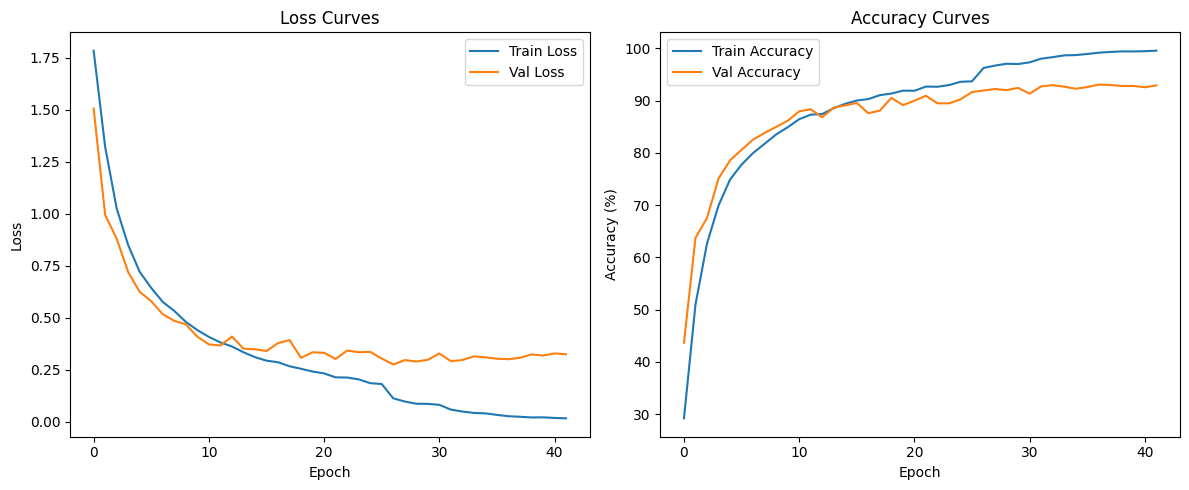

Training completed with best validation accuracy: 93.04%


In [32]:
def train_model(model, train_loader, val_loader, num_epochs=10, early_stop_patience=7):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_acc = 0.0
    best_model_wts = model.state_dict().copy()

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    no_improvement_counter = 0  # for early stopping

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Validate
        val_loss, val_acc, all_preds, all_labels = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Scheduler step
        scheduler.step(val_loss)

        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            no_improvement_counter = 0  # reset counter
            print(f"New best model with validation accuracy: {val_acc:.2f}%")
        else:
            no_improvement_counter += 1
            print(f"No improvement for {no_improvement_counter} epoch(s).")

        # Early stopping condition
        if no_improvement_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.tight_layout()
    plt.show()

    return model, best_val_acc

# Run training with 50 epochs and early stopping
num_epochs = 50
early_stop_patience = 5
finetuned_model, best_acc = train_model(model, train_loader, val_loader, num_epochs=num_epochs, early_stop_patience=early_stop_patience)

print(f"Training completed with best validation accuracy: {best_acc:.2f}%")


In [33]:
def save_model(model, save_path):
    """Save the model to the specified path"""
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

    # Save the model
    if hasattr(model, 'save_pretrained'):
        # For transformers models
        model.save_pretrained(save_path)
        print(f"Model saved to {save_path} using save_pretrained")
    else:
        # For regular PyTorch models
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path} using torch.save")

# Save the model
save_path = '/workspace/TRY/model1/model1.pt'  # <-- add a filename
save_model(finetuned_model, save_path)

Model saved to /workspace/TRY/model1/model1.pt using torch.save


In [34]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Set Evaluation:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Test Set Evaluation:
              precision    recall  f1-score   support

       angry       0.92      0.94      0.93       593
     disgust       0.94      0.95      0.95       504
        fear       0.97      0.97      0.97       537
       happy       0.99      0.98      0.99       549
     neutral       0.80      0.83      0.81       570
         sad       0.93      0.90      0.91       502
    surprise       0.95      0.91      0.93       541

    accuracy                           0.93      3796
   macro avg       0.93      0.93      0.93      3796
weighted avg       0.93      0.93      0.93      3796



In [22]:
def predict_expression(model, image_path, transform=None, device=None):
    """
    Predict the facial expression in an image

    Args:
        model: The trained model
        image_path: Path to the image file
        transform: Transformation to apply to the image
        device: Device to run inference on

    Returns:
        Predicted class name and confidence score
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        if hasattr(outputs, 'logits'):
            outputs = outputs.logits

        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    # Get class names
    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    return predicted_class, confidence_score

# Test the model on a sample image
sample_image_path = '/content/pic.jpeg'  # Update this to your test image path

if os.path.exists(sample_image_path):
    predicted_class, confidence = predict_expression(
        finetuned_model,
        sample_image_path,
        transform=val_transform,
        device=device
    )

    print(f"Predicted expression: {predicted_class} with {confidence:.2f}% confidence")

    # Display the image with prediction
    image = Image.open(sample_image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
else:
    print(f"Sample image not found at {sample_image_path}")

Sample image not found at /content/pic.jpeg
